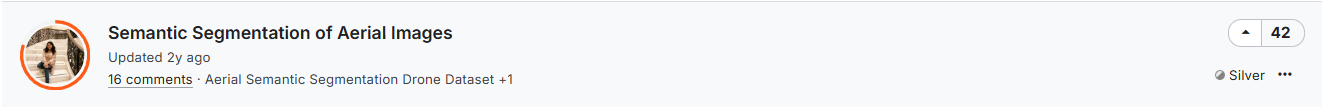

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import tensorflow as tf
from tensorflow.keras.utils import Sequence
import random
from sklearn.model_selection import train_test_split

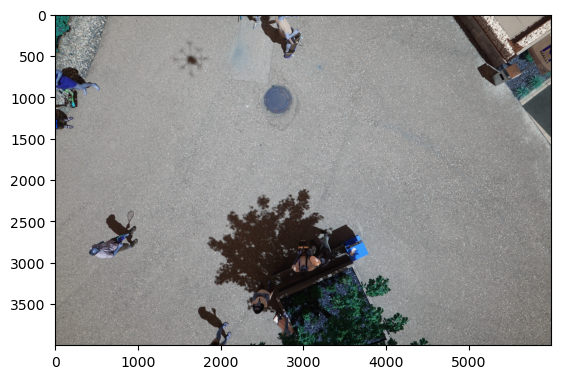

In [2]:
dir_path =r"D:\code_study\ML_CODE\dataSets\Segmentation\Aerial_Semantic_Segmentation_Drone_Dataset\archive\dataset\semantic_drone_dataset"
dir_path = dir_path.replace('\\','/')

img1=cv2.imread(dir_path + '/original_images/000.jpg')
plt.imshow(img1)

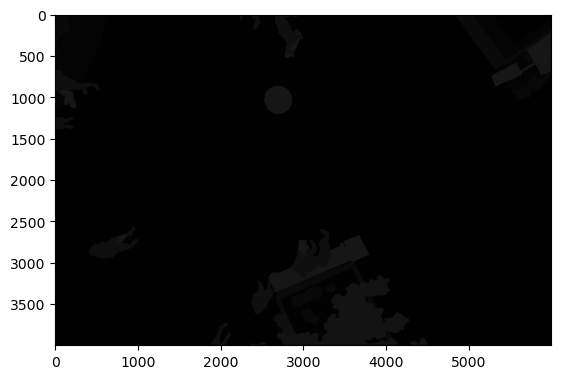

In [3]:
img2=cv2.imread(dir_path + '/label_images_semantic/000.png')
plt.imshow(img2)

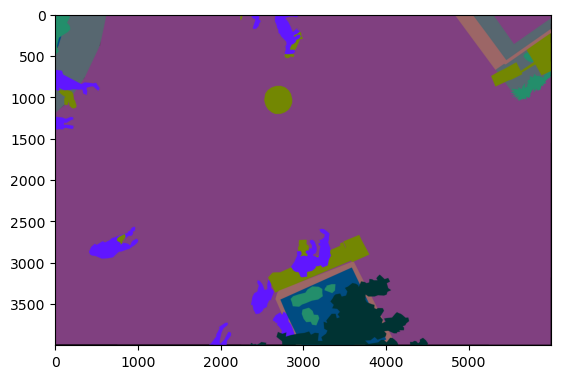

In [4]:
img3=cv2.imread(r"D:\code_study\ML_CODE\dataSets\Segmentation\Aerial_Semantic_Segmentation_Drone_Dataset\archive\RGB_color_image_masks\RGB_color_image_masks/000.png")
plt.imshow(img3)

In [5]:
num_classes=23
H=800
W=1200

def read_image(x):
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32) ##image dtype is Float32
    return x


def read_mask(x):
    x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    x = x.astype(np.int32) ##mask dtype is Int32
    return x


def tf_dataset(x,y, batch=4):
    dataset = tf.data.Dataset.from_tensor_slices((x,y)) # Dataset data object created from input and target data
    dataset = dataset.shuffle(buffer_size=100) ## selected from the first 100 samples
    dataset = dataset.map(preprocess) # Applying preprocessing to every batch in the Dataset object
    dataset = dataset.batch(batch) # Determine batch-size
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2) # Optimization to reduce waiting time on each object
    return dataset
        

def preprocess(x,y):
    def f(x,y):
        x = x.decode() ##byte stream conversion
        y = y.decode()
        image = read_image(x)
        mask = read_mask(y)
        return image, mask
    
    image, mask = tf.numpy_function(f,[x,y],[tf.float32, tf.int32])
    mask = tf.one_hot(mask, num_classes, dtype=tf.int32)
    image.set_shape([H, W, 3])    # In the Images, number of channels = 3. 
    mask.set_shape([H, W, num_classes])    # In the Masks, number of channels = number of classes. 
    return image, mask

In [6]:

img_path = dir_path + '/original_images/'
mask_path = dir_path + '/label_images_semantic/'

names = list(map(lambda x: x.replace('.jpg', ''), os.listdir(img_path))) 
 ##his is using the map function to apply a lambda function to each element in the list of filenames returned by os.listdir(img_path). The lambda function takes a single argument x and returns x with '.jpg' replaced by an empty string. The result of the map function will be a new list containing the modified strings.
names

['000',
 '001',
 '002',
 '003',
 '004',
 '005',
 '006',
 '008',
 '011',
 '013',
 '014',
 '015',
 '016',
 '018',
 '019',
 '021',
 '022',
 '023',
 '026',
 '028',
 '031',
 '035',
 '038',
 '040',
 '041',
 '042',
 '043',
 '044',
 '045',
 '047',
 '049',
 '051',
 '052',
 '053',
 '055',
 '056',
 '057',
 '058',
 '059',
 '060',
 '062',
 '063',
 '065',
 '068',
 '070',
 '071',
 '073',
 '074',
 '075',
 '077',
 '078',
 '079',
 '080',
 '081',
 '083',
 '086',
 '088',
 '089',
 '092',
 '095',
 '098',
 '099',
 '100',
 '101',
 '102',
 '103',
 '104',
 '106',
 '107',
 '109',
 '110',
 '111',
 '112',
 '113',
 '116',
 '117',
 '118',
 '119',
 '120',
 '121',
 '122',
 '123',
 '124',
 '126',
 '128',
 '130',
 '133',
 '134',
 '135',
 '136',
 '137',
 '138',
 '139',
 '140',
 '141',
 '145',
 '146',
 '147',
 '148',
 '149',
 '150',
 '153',
 '154',
 '155',
 '156',
 '157',
 '158',
 '159',
 '160',
 '161',
 '162',
 '163',
 '164',
 '165',
 '166',
 '167',
 '170',
 '171',
 '172',
 '173',
 '174',
 '175',
 '176',
 '177',
 '178',


In [7]:
X_trainval, X_test = train_test_split(names, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.2, random_state=19)

print(f"Train Size : {len(X_train)} images")
print(f"Val Size   :  {len(X_val)} images")
print(f"Test Size  :  {len(X_test)} images")

y_train = X_train
y_test = X_test
y_val = X_val

img_train = [os.path.join(img_path, f"{name}.jpg") for name in X_train]
mask_train = [os.path.join(mask_path, f"{name}.png") for name in y_train]
img_val = [os.path.join(img_path, f"{name}.jpg") for name in X_val]
mask_val = [os.path.join(mask_path, f"{name}.png") for name in y_val]
img_test = [os.path.join(img_path, f"{name}.jpg") for name in X_test]
mask_test = [os.path.join(mask_path, f"{name}.png") for name in y_test]

Train Size : 288 images
Val Size   :  72 images
Test Size  :  40 images


In [8]:
batch_size=2

train_dataset = tf_dataset(img_train, mask_train, batch = batch_size)
valid_dataset = tf_dataset(img_val, mask_val, batch = batch_size)

train_steps = len(img_train)//batch_size
valid_steps = len(img_val)//batch_size

In [9]:
## sanity check
print(train_steps)

144


In [10]:
num_classes=23
H=800
W=1200


def test_dataset(x, batch=32):
    dataset = tf.data.Dataset.from_tensor_slices(x)
    dataset = dataset.map(preprocess_test)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(2)
    return dataset
        

def preprocess_test(x):
    def f(x):
        x = x.decode()
        image = read_image(x)
        return image
    
    image = tf.convert_to_tensor(tf.numpy_function(f, [x] , [tf.float32]))
    image = tf.reshape(image, (H, W, 3))    # In the Images, number of channels = 3.  
    return image

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda


def multi_unet_model(n_classes=23, IMG_HEIGHT=800, IMG_WIDTH=1200, IMG_CHANNELS=3):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.1)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.1)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.1)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    model.compile(optimizer='adam', loss=['categorical_crossentropy'], metrics=['accuracy'])
    
    model.summary()
    
    return model

In [12]:
model = multi_unet_model()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 800, 1200, 3 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 800, 1200, 16 448         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 800, 1200, 16 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 800, 1200, 16 2320        dropout[0][0]                    
______________________________________________________________________________________________

In [13]:
es = tf.keras.callbacks.EarlyStopping(min_delta=0.001, patience=5)

In [14]:
history = model.fit(train_dataset,
          steps_per_epoch=train_steps,
          validation_data=valid_dataset,
          validation_steps=valid_steps,
          epochs=50
         )

Epoch 1/50
144/144 [==============================] - 128s 832ms/step - loss: 2.5421 - accuracy: 0.3133 - val_loss: 2.0055 - val_accuracy: 0.5031
Epoch 2/50
144/144 [==============================] - 116s 811ms/step - loss: 1.8429 - accuracy: 0.5212 - val_loss: 1.9061 - val_accuracy: 0.5309
Epoch 3/50
144/144 [==============================] - 113s 788ms/step - loss: 1.6177 - accuracy: 0.5611 - val_loss: 1.5585 - val_accuracy: 0.5688
Epoch 4/50
 87/144 [=================>............] - ETA: 35s - loss: 1.4933 - accuracy: 0.5878

KeyboardInterrupt: 

In [ ]:
model.save("version2.h5")

In [ ]:
model =  tf.keras.models.load_model('./version2.h5') 

In [ ]:
test_ds = tf_dataset(img_test, mask_test, batch = batch_size)
model.evaluate(test_ds, steps=14)

In [ ]:
pred = model.predict(test_dataset(img_test, batch = 1), steps=40)

In [ ]:
pred.shape

In [ ]:
predictions = np.argmax(pred, axis=3)
label = np.array([cv2.resize(cv2.imread(mask_path+img_test[i][-7:-4]+'.png')[:, :, 0], (1200, 800)) for i in range(predictions.shape[0])])
label = label.flatten()
predictions = predictions.flatten()

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix
csv_path = "D:\code_study\ML_CODE\dataSets\Segmentation\Aerial_Semantic_Segmentation_Drone_Dataset\archive"
df = pd.read_csv(csv_path)
cm = confusion_matrix(label, predictions)

In [ ]:
df_cm = pd.DataFrame(cm)
df_cm

In [ ]:
import seaborn as sns
sns.set_theme()

ax = sns.heatmap(df_cm, annot_kws={"size": 10}, fmt=".1f", cmap="YlGnBu")

In [ ]:
cmap = np.array(list(df[[' r', ' g', ' b']].transpose().to_dict('list').values()))
predictions = predictions.reshape(-1, 800, 1200)
label = label.reshape(-1, 800, 1200)

i = 18

fig, ax = plt.subplots(3, 2, figsize=(15, 15))
for j in range(3):
    ax[j, 0].imshow(cmap[predictions[i+j]])
    ax[j, 1].imshow(cmap[label[i+j]])
    ax[j, 0].set_title('Prediction')
    ax[j, 1].set_title('Ground truth')
    ax[j, 0].grid(False)
    ax[j, 1].grid(False)
    
plt.show()

In [ ]:
!pip install -q streamlit

In [ ]:
!pip install pyngrok

In [ ]:
from pyngrok import ngrok
public_url = ngrok.connect(port='8501')
public_url
     

In [ ]:
%%writefile streamlit_app.py
#Library imports
import numpy as np
import streamlit as st
import cv2
from keras.models import load_model
#import joblib
from keras.preprocessing import image
from io import BytesIO




#Loading the Model
model = load_model('/kaggle/working/version2.h5', compile=False)


st.markdown("## Aerial Image Segmentation App")
st.markdown(""" This app accepts aerial images of landscapes and returns segmented predictions

**Made by Sanya Sinha**

""")



st.markdown("Upload an image of the object")

#Uploading the  image
object_image = st.file_uploader("Upload an image...", type=['png','jpg','webp'])
submit = st.button('Predict')
#On predict button click
if submit:

    if object_image is not None:

        # Convert the file to an opencv image.
        file_bytes = np.asarray(bytearray(object_image.read()), dtype=np.uint8)
        opencv_image = cv2.imdecode(file_bytes, 1)
        st.image(opencv_image, channels="BGR")
        opencv_image = cv2.resize(opencv_image, (224,224))
        opencv_image.shape = (1,224,224,3)
        predictions = model.predict(opencv_image)
        predicted_classes = multi_unet_model.decode_predictions(predictions, top=5)



        # Displaying the image
        #st.image(object_image, channels="BGR")
        st.text('The image is: ')

        for imagenet_id, name, likelihood in predicted_classes[0]:
            st.text('- {}: {:.2f} likelihood'.format(name,likelihood))
            
if __name__ == '__main__':
    main()